In [2]:
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as md
np.set_printoptions(threshold=sys.maxsize)

In [15]:
arr = np.genfromtxt("./trade_prices_eth.csv", delimiter=",")
tm = np.array([datetime.datetime.fromtimestamp(ts/1000) for ts in arr[:,0]]).reshape(len(arr[:,0]),1)
tm = tm[:-10000]
prices = arr[:,1].reshape(len(arr[:,1]),1)
prices = prices[:-10000]

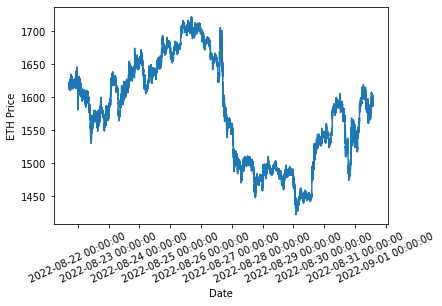

In [5]:
plt.plot(tm, prices)
plt.ylabel("ETH Price")
plt.xlabel("Date")
plt.xticks(rotation=25)
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)
plt.show()

In [24]:
#Optimisation method for time window and multiplication factor:
# - Calculate std = sqrt(Mean(log(Pt/Pt-1)**2)) for a certain time window, shifting the window over the whole 1 year period
# - Multiply by k
# - Check that we have for the full 1 year period k*std > log(Pt+1/Pt)

In [16]:
time_window = 50
jump = 5
prices_update = prices[::jump]
time = tm[::jump]

In [37]:
ks = [temp for temp in range(20,30)]
time_windows = [time*jump for time in range(5, 12)]
min_diff = 10
min_k = 0
min_window = 0
for k in ks:
    for time_window in time_windows:
        print("current window", time_window, "current k", k)
        ratio = int(time_window / jump)
        skips = time[ratio+1:-1] - time[ratio:-2] < datetime.timedelta(seconds=6)
        
        stds = [
            np.sqrt(np.mean((np.log(prices_update[i-ratio+1:i+1]/prices_update[i-ratio:i]))**2)) 
                for i in range(ratio, len(prices_update)-2)
        ]
        stds = np.array(stds).reshape(len(stds),1)
        returns = np.abs(np.log(prices_update[ratio+1:-1]/prices_update[ratio:-2]))
        diff = np.maximum(k*stds, np.log(1.01)) - returns
        minimum = min(diff)
        print("minimum", minimum)
        if minimum > 0 and min_diff > minimum :
            print("smallest k", k)
            print("window", time_window)
            min_k = k
            min_window = time_window
            min_diff = minimum

current window 25 current k 100


KeyboardInterrupt: 

In [24]:
# Test and debugging
ratio = int(time_window / jump)
k = 20
skips = time[ratio+1:-1] - time[ratio:-2] < datetime.timedelta(seconds=6)

stds = [
    np.sqrt(np.mean((np.log(prices_update[i-ratio+1:i+1]/prices_update[i-ratio:i]))**2)) 
        for i in range(ratio, len(prices_update)-2)
]
stds = np.array(stds).reshape(len(stds),1)
returns = np.abs(np.log(prices_update[ratio+1:-1]/prices_update[ratio:-2]))
diff = np.maximum(k*stds[skips], np.log(1.01)) - returns[skips]
minimum = min(diff)

In [27]:
print(np.where(diff<0))
index = 3009194
ret = returns[skips]
t = time[ratio:-2][skips]
print("PRICE SKIPPED", prices_update[ratio+1:-1][skips][index], prices_update[ratio:-2][skips][index])
print(t[index], t[index+1])
print("DIFF", diff[index])

(array([3009194]),)
PRICE SKIPPED 1200.0189671858275 1181.3894268138151
2022-06-24 13:31:49.999000 2022-06-24 13:31:54.999000
DIFF -0.0009602334239460133


In [10]:
def normal_to_jump(index_normal):
    return int(index_normal/5) - ratio

In [11]:
def jump_to_normal(index_jump):
    return (index_jump + ratio) * 5